In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [9]:
# aggregate energy results for each control strategy
simulation_timeStep = 0.2 # used to calculate travel time
powertrain_tech = "ICEV"
petroleum_equivalent_factor = 28996 # old value is 23160
fueltype = ["ICEV_fuel", "BEV_energy", "PHEV_electric_power", "PHEV_fuel", "HFCV_energy", "hev_fuel"]
control_method = ["No_control", "Signal_optimization_only", "Eco-Driving_only", "Proposed_control"]
demand_perct = [10, 50, 100]
cav_perct = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# major_sections = [5284,1246,1267,1248,1269,1249,1270,1272,1252,1253,1274,1275,1254,1282,1261,1262,1283,1263,1284]
energy_df = pd.DataFrame(columns=['control_method', 'demand_percent', 'cav_percent', 'average_energy_consumption', 'travel_time'])

for control_strategy in control_method:
    for demand in demand_perct:
        for cav in cav_perct:
            files = "results/" + control_strategy + "_demand" + str(demand) + "_CAV" + str(cav) + '_*.csv'
            file_list = glob.glob(files)
            
            energy_per_km_per_vehicle = 0
            avg_travel_time = 0
            num_repli = 0

            for file in file_list:
                df = pd.read_csv(file, delimiter='\t')
                num_repli += 1
                veh_ids = df.vehicle_id.unique()
                num_vehicles = len(veh_ids)
                energy_per_km = 0
                travel_time = 0
                for idx in veh_ids:
                    df_by_vehicle = df[df['vehicle_id']==idx]
                    travel_time += df_by_vehicle.shape[0] * simulation_timeStep / 60 # convert to minutes
                    cumulative_distance = df_by_vehicle['driving_distance'].sum()

                    if powertrain_tech == "ICEV":
                        total_energy = df_by_vehicle[fueltype[0]].sum()
                    elif powertrain_tech == "BEV":
                        total_energy = df_by_vehicle[fueltype[1]].sum() / petroleum_equivalent_factor
                    elif powertrain_tech == "PHEV":
                        total_energy_1 = df_by_vehicle[fueltype[2]].sum()
                        total_energy_2 = df_by_vehicle[fueltype[3]].sum()
                        total_energy = total_energy_1 / petroleum_equivalent_factor + total_energy_2 
                    elif powertrain_tech == "HFCV":
                        total_energy = df_by_vehicle[fueltype[4]].sum()
                    elif powertrain_tech == "HEV":
                        total_energy = df_by_vehicle[fueltype[5]].sum()
                    
                    energy_per_km += total_energy / cumulative_distance
                
                avg_travel_time += travel_time / num_vehicles
                energy_per_km_per_vehicle += energy_per_km / num_vehicles

            repliAvg_energy_per_km = energy_per_km_per_vehicle / num_repli
            repliAvg_travel_time = avg_travel_time / num_repli
            df1 = pd.DataFrame({'control_method': [control_strategy], 'demand_percent' :[demand], 'cav_percent': [cav], 'average_energy_consumption': [repliAvg_energy_per_km], 'travel_time': [repliAvg_travel_time]})
            energy_df = energy_df.append(df1, ignore_index = True)



In [30]:
df_test = energy_df.loc[(energy_df['demand_percent'] == 100) & (energy_df['cav_percent'] == 60)]
df_test.head()

,control_method,demand_percent,cav_percent,average_energy_consumption,travel_time
28,No_control,100,60,0.000633,2.841684
61,Signal_optimization_only,100,60,0.000414,1.781182
94,Eco-Driving_only,100,60,0.000594,2.583042
127,Proposed_control,100,60,0.000416,1.781394


In [11]:
energy_df.to_csv('agg_results/average_energy_results.csv', sep='\t')

In [35]:
energy_df.head(100)

,control_method,demand_percent,cav_percent,average_energy_consumption,travel_time
0,No_control,10,0,0.000519,2.272336
1,No_control,10,10,0.000520,2.249222
2,No_control,10,20,0.000506,2.242679
3,No_control,10,30,0.000511,2.237655
4,No_control,10,40,0.000519,2.250388
...,...,...,...,...,...
95,Eco-Driving_only,100,70,0.000590,2.556982
96,Eco-Driving_only,100,80,0.000591,2.571529
97,Eco-Driving_only,100,90,0.000627,2.789773
98,Eco-Driving_only,100,100,0.000583,2.544032


In [12]:
# calculate energy savings for each control strategy
savings = pd.DataFrame(columns=['demand', 'cav', 'signal_optimization', 'signal_optimization_tt', 'eco-drive_only', 'eco-drive_only_tt','cooperative_control', 'cooperative_control_tt'])

for demand in demand_perct:
    for cav in cav_perct:
        energy_no_control = energy_df.loc[(energy_df['control_method']=='No_control') & (energy_df['demand_percent']==demand)
                                          & (energy_df['cav_percent']==cav), 'average_energy_consumption'].item()
        tt_no_control = energy_df.loc[(energy_df['control_method']=='No_control') & (energy_df['demand_percent']==demand)
                                          & (energy_df['cav_percent']==cav), 'travel_time'].item()
        
        energy_sig_opt = energy_df.loc[(energy_df['control_method']=='Signal_optimization_only') & (energy_df['demand_percent']==demand)
                                          & (energy_df['cav_percent']==cav), 'average_energy_consumption'].item()
        tt_sig_opt = energy_df.loc[(energy_df['control_method']=='Signal_optimization_only') & (energy_df['demand_percent']==demand)
                                          & (energy_df['cav_percent']==cav), 'travel_time'].item()
        
        energy_eco_drive = energy_df.loc[(energy_df['control_method']=='Eco-Driving_only') & (energy_df['demand_percent']==demand)
                                          & (energy_df['cav_percent']==cav), 'average_energy_consumption'].item()
        tt_eco_drive = energy_df.loc[(energy_df['control_method']=='Eco-Driving_only') & (energy_df['demand_percent']==demand)
                                          & (energy_df['cav_percent']==cav), 'travel_time'].item()
        
        energy_cooperative_control = energy_df.loc[(energy_df['control_method']=='Proposed_control') & (energy_df['demand_percent']==demand)
                                          & (energy_df['cav_percent']==cav), 'average_energy_consumption'].item()
        tt_cooperative_control = energy_df.loc[(energy_df['control_method']=='Proposed_control') & (energy_df['demand_percent']==demand)
                                          & (energy_df['cav_percent']==cav), 'travel_time'].item()
        
        energy_saving_sig_opt = (energy_no_control - energy_sig_opt) / energy_no_control * 100
        tt_saving_sig_opt = (tt_no_control - tt_sig_opt) / tt_no_control * 100
        energy_saving_eco_drive = (energy_no_control - energy_eco_drive) / energy_no_control * 100
        tt_saving_eco_drive = (tt_no_control - tt_eco_drive) / tt_no_control * 100
        energy_saving_cooperative_control = (energy_no_control - energy_cooperative_control) / energy_no_control * 100
        tt_saving_cooperative_control = (tt_no_control - tt_cooperative_control) / tt_no_control * 100

        df2 = pd.DataFrame({'demand': [demand], 'cav': [cav], 'signal_optimization': [energy_saving_sig_opt], 'signal_optimization_tt': [tt_saving_sig_opt], \
                            'eco-drive_only': [energy_saving_eco_drive], 'eco-drive_only_tt': [tt_saving_eco_drive], 'cooperative_control': [energy_saving_cooperative_control], \
                            'cooperative_control_tt': [tt_saving_cooperative_control]})
        savings = savings.append(df2, ignore_index = True)
    


In [13]:
savings.to_csv('agg_results/energy_saving.csv')

In [34]:
savings.head(100)

,demand,cav,signal_optimization,signal_optimization_tt,eco-drive_only,eco-drive_only_tt,cooperative_control,cooperative_control_tt
0,10,0,0.247341,0.074672,0.000000,0.000000,0.247341,0.074672
1,10,10,-2.611216,-4.273913,0.023893,-0.102011,-2.619189,-4.315786
2,10,20,-5.380115,-4.800759,0.187959,0.095437,-5.463602,-4.903733
3,10,30,-2.503736,-2.127445,-0.137578,-0.499563,-2.408605,-2.233117
4,10,40,0.019348,-1.362321,0.013890,-0.303640,-0.079813,-1.530886
5,10,50,-2.650395,-1.034688,-0.095297,-0.486630,-2.639646,-1.097184
6,10,60,-0.235868,-1.574003,0.168079,-0.269272,-0.470434,-1.914883
7,10,70,-2.599194,-1.970069,0.371792,-0.345497,-2.602747,-2.250603
8,10,80,-4.605393,-3.774245,0.591472,-0.080562,-5.120294,-4.401074
9,10,90,-2.028929,-1.512398,-0.418158,-1.037800,-2.093674,-1.794423


5 2
5 2
5 2
5 2
5 2
5 2
5 2
5 2
5 2
5 2


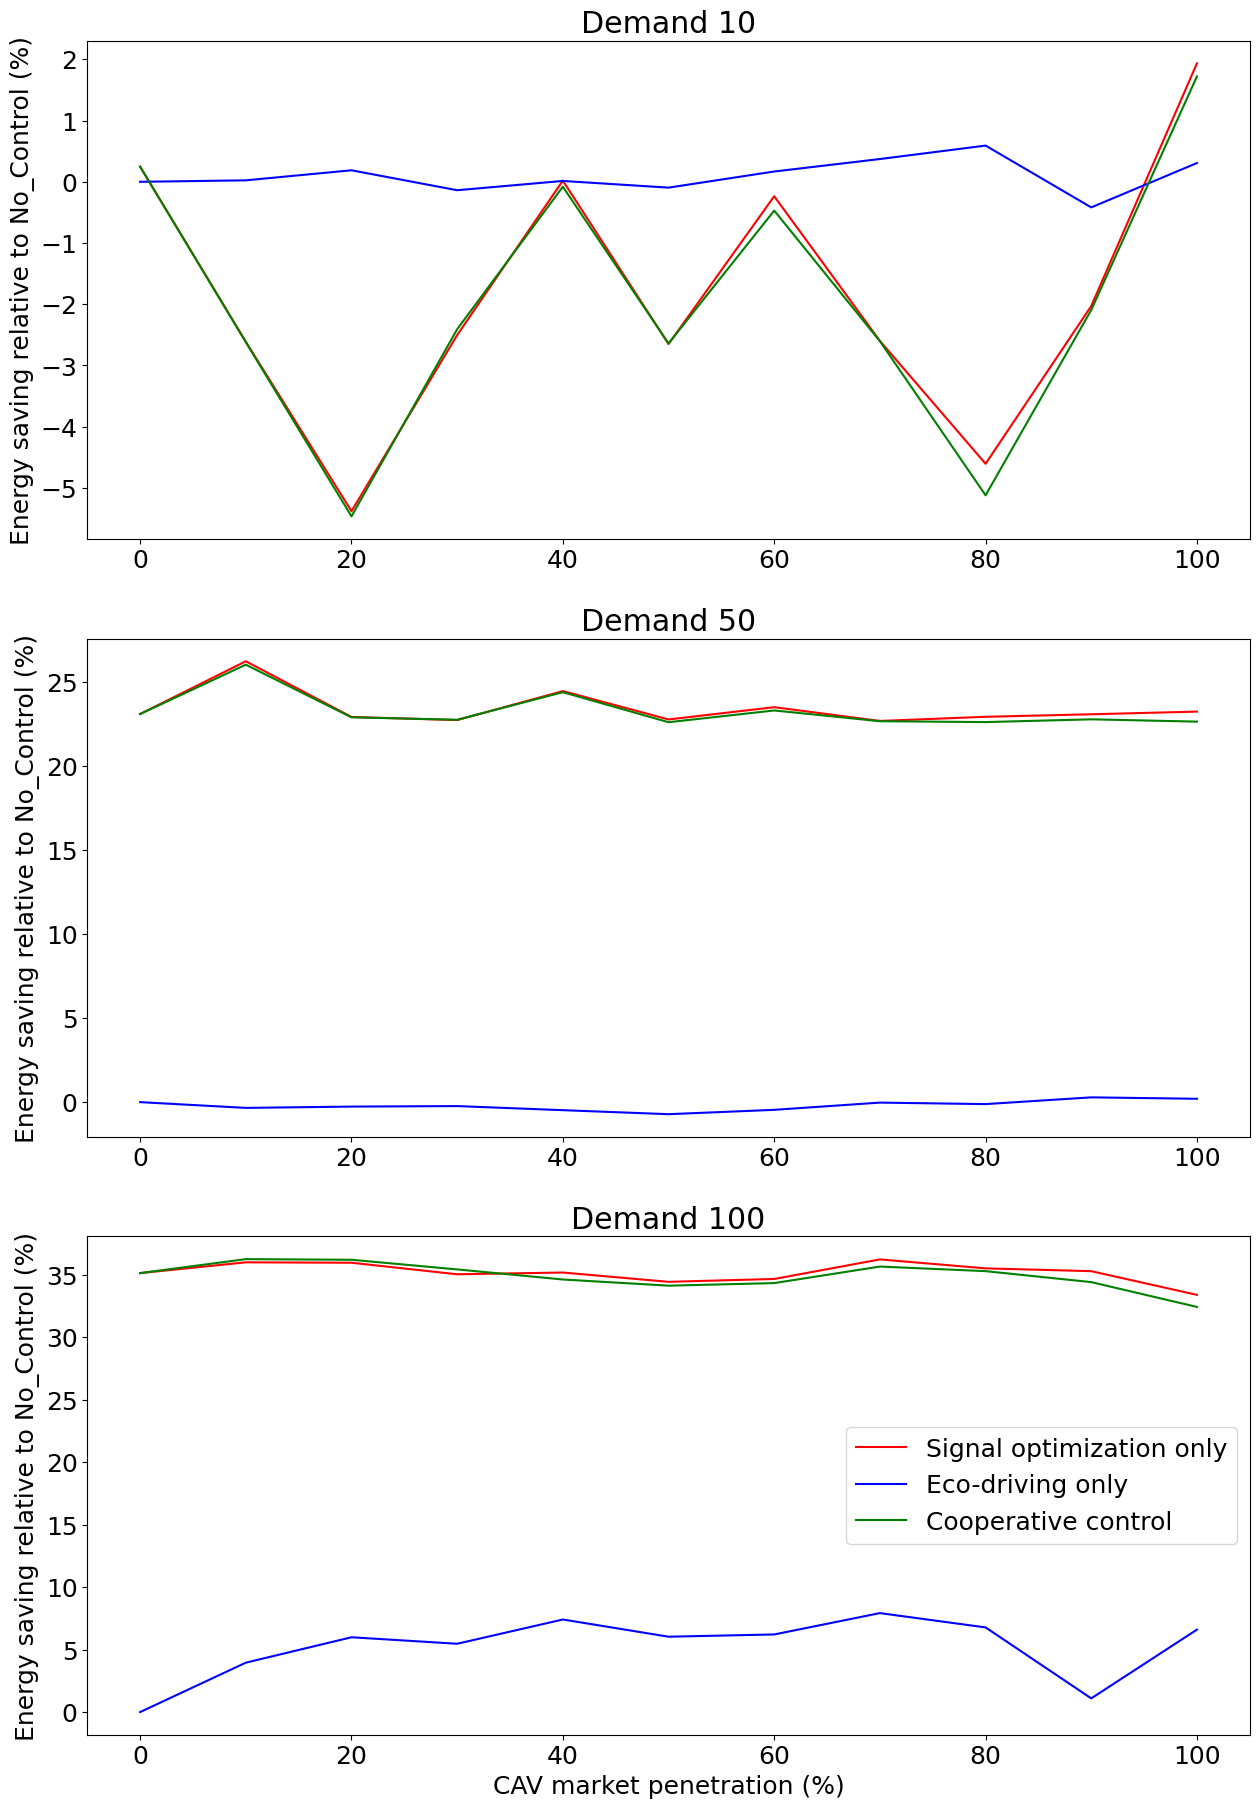

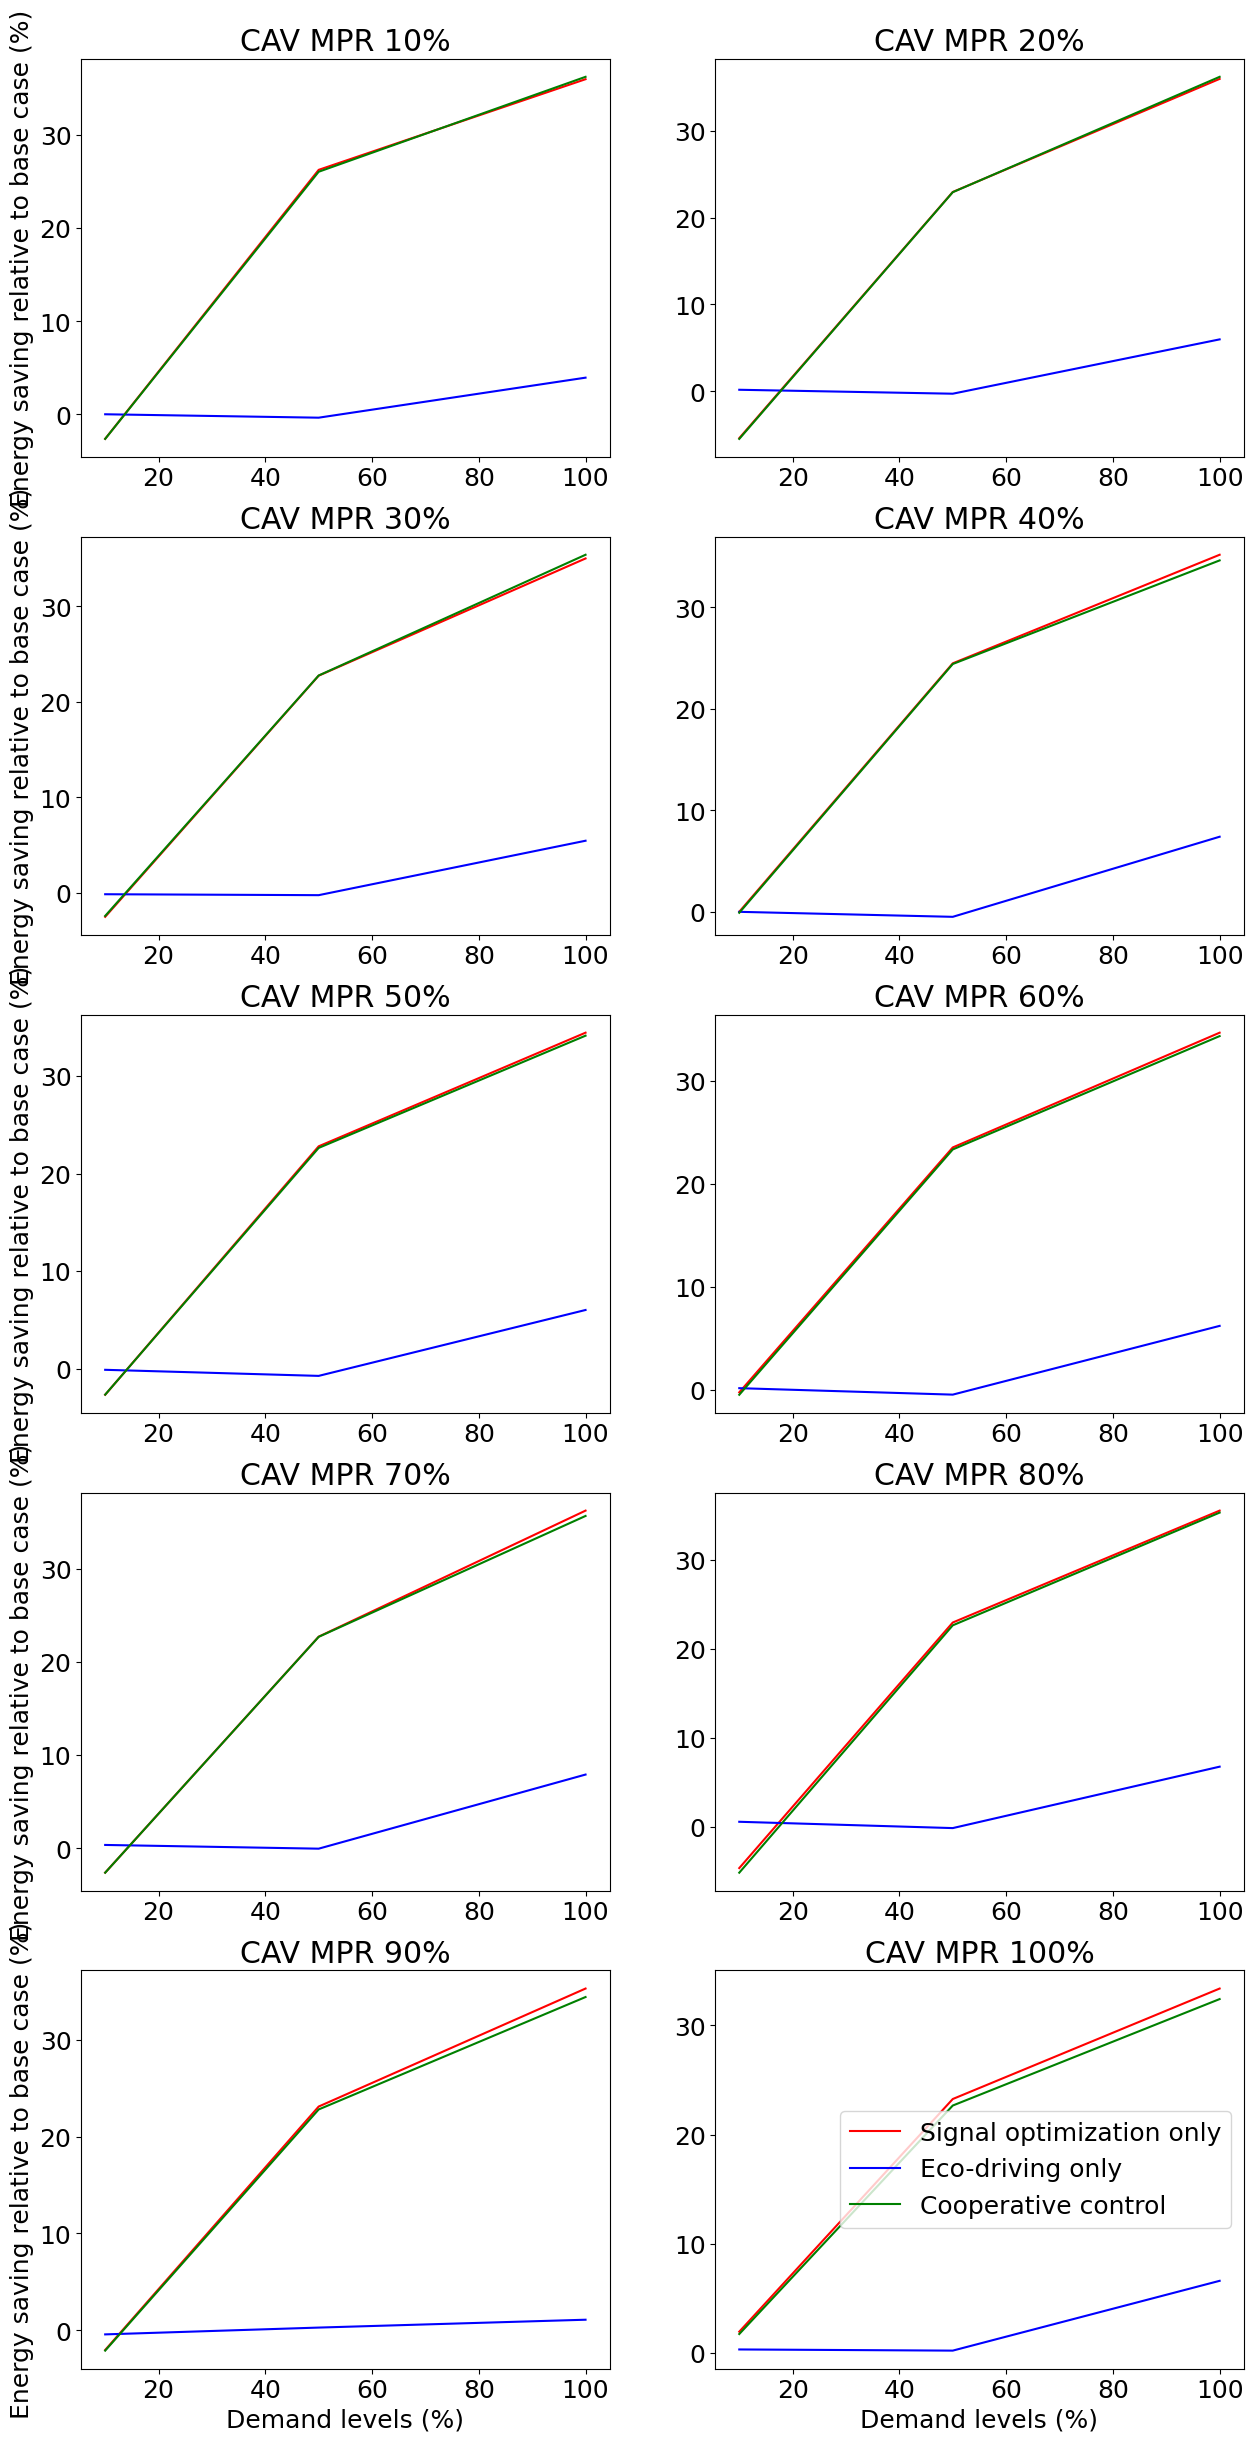

In [ ]:
# results visualization
demand_perct = [10, 50, 100]

# energy_saving vs. cav_percent
cav_perct = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure(figsize=(15, 22))
num_row = 3
num_fig_per_row = int(len(demand_perct) / num_row)
subplot_idx = 1
plt.rcParams.update({'font.size': 18})

for demand in demand_perct:
    energy_saving_sig_opt = savings.loc[savings['demand'] == demand, 'signal_optimization']
    energy_saving_eco_drive = savings.loc[savings['demand'] == demand, 'eco-drive_only']
    energy_saving_cooperative_control = savings.loc[savings['demand'] == demand, 'cooperative_control']
    plt.subplot(num_row, num_fig_per_row, subplot_idx)
    plt.plot(cav_perct, energy_saving_sig_opt, 'r')
    plt.plot(cav_perct, energy_saving_eco_drive, 'b')
    plt.plot(cav_perct,energy_saving_cooperative_control, 'g')
    plt.ylabel('Energy saving relative to No_Control (%)')
    plt.title('Demand {}'.format(demand))

    if subplot_idx == len(demand_perct):
        plt.xlabel('CAV market penetration (%)')
        plt.legend(['Signal optimization only', 'Eco-driving only', 'Cooperative control'])
    
    subplot_idx += 1

# energy saving vs. demand
cav_perct = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure(figsize=(15, 30))
num_row = 5
num_fig_per_row = int(len(cav_perct) / num_row)
subplot_idx = 1
plt.rcParams.update({'font.size': 18})

for cav in cav_perct:
    energy_saving_sig_opt = savings.loc[savings['cav'] == cav, 'signal_optimization']
    energy_saving_eco_drive = savings.loc[savings['cav'] == cav, 'eco-drive_only']
    energy_saving_cooperative_control = savings.loc[savings['cav'] == cav, 'cooperative_control']
    plt.subplot(num_row, num_fig_per_row, subplot_idx)
    plt.plot(demand_perct, energy_saving_sig_opt, 'r')
    plt.plot(demand_perct, energy_saving_eco_drive, 'b')
    plt.plot(demand_perct,energy_saving_cooperative_control, 'g')
    plt.title('CAV MPR {}%'.format(cav))

    if subplot_idx % 2 == 1:
        plt.ylabel('Energy saving relative to base case (%)')
    
    if subplot_idx == len(cav_perct)-1:
        plt.xlabel('Demand levels (%)')

    if subplot_idx == len(cav_perct):
        plt.xlabel('Demand levels (%)')
        plt.legend(['Signal optimization only', 'Eco-driving only', 'Cooperative control'])
    
    subplot_idx += 1

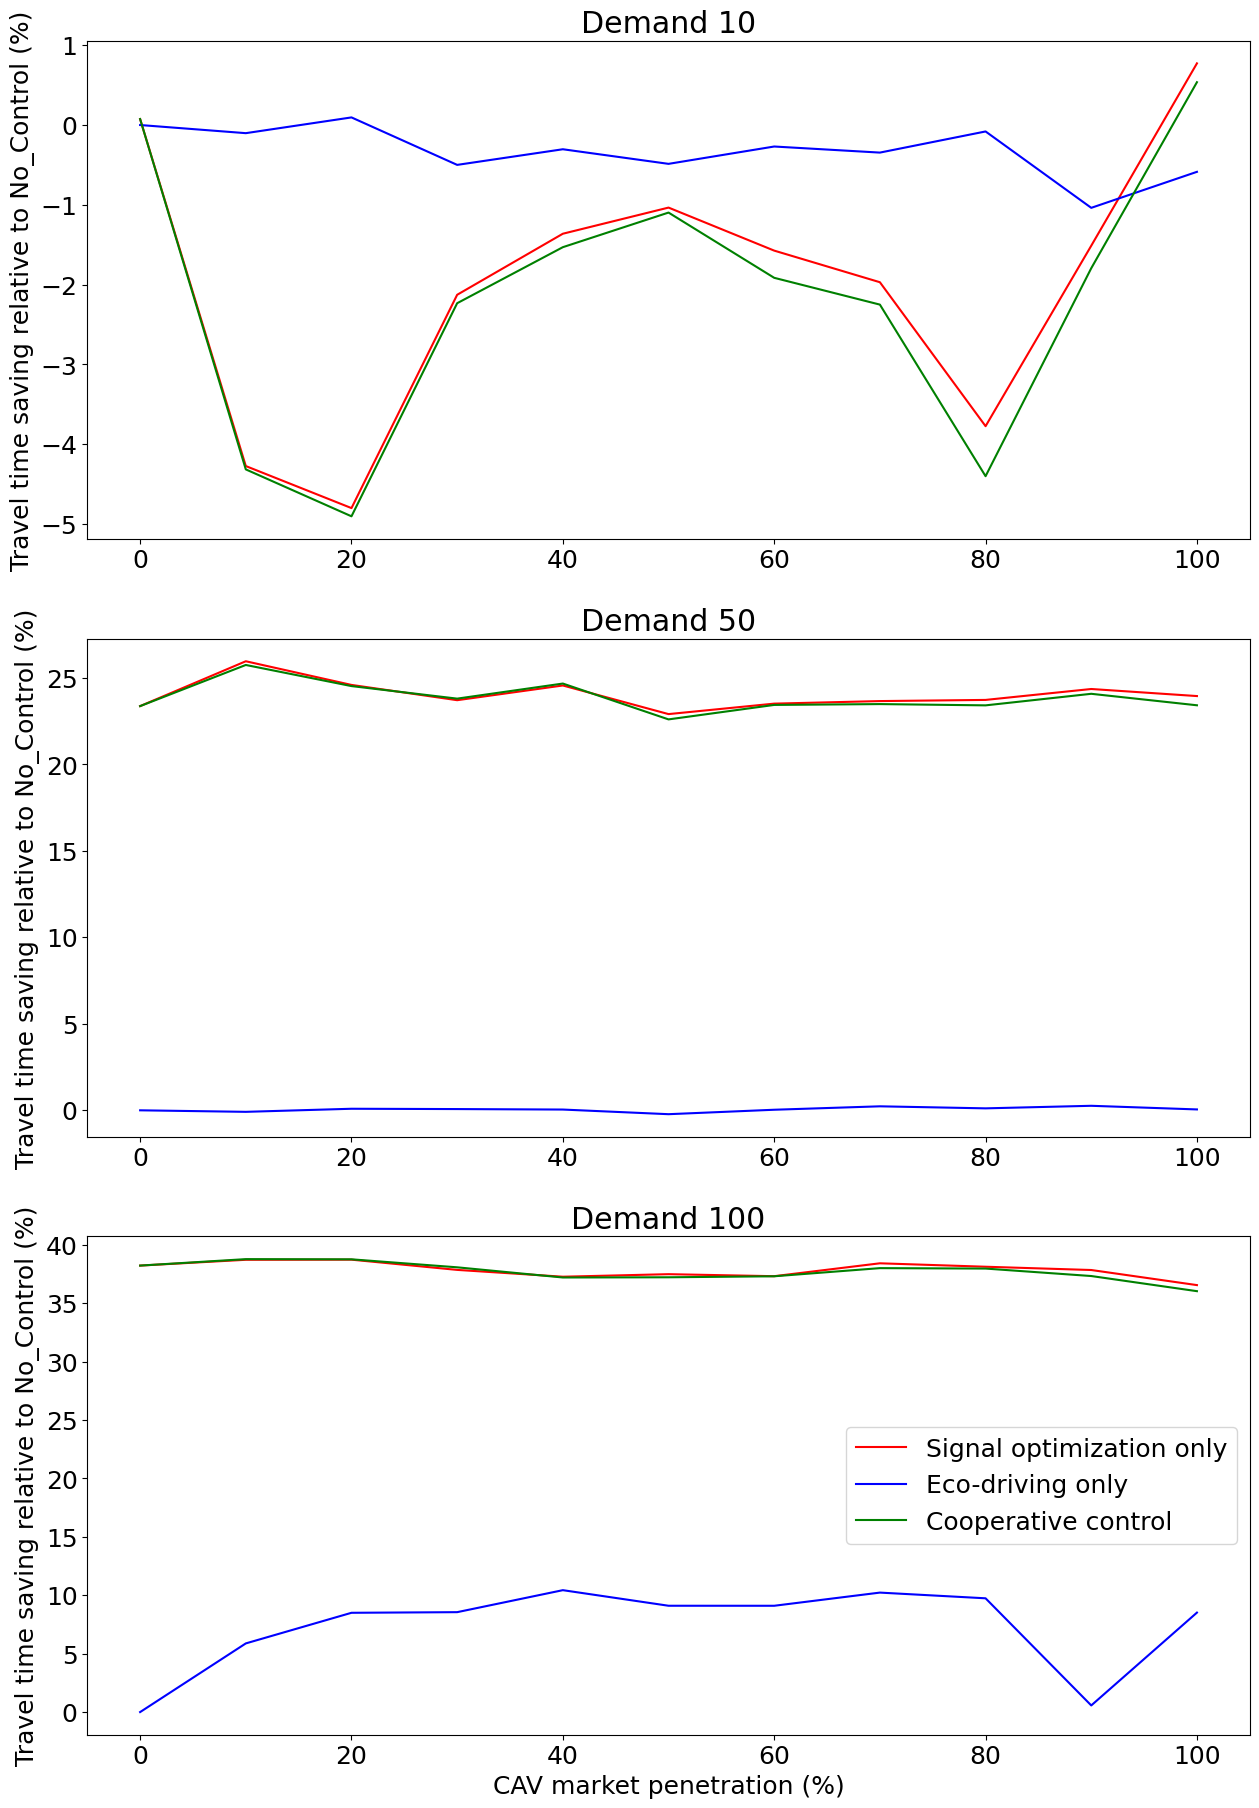

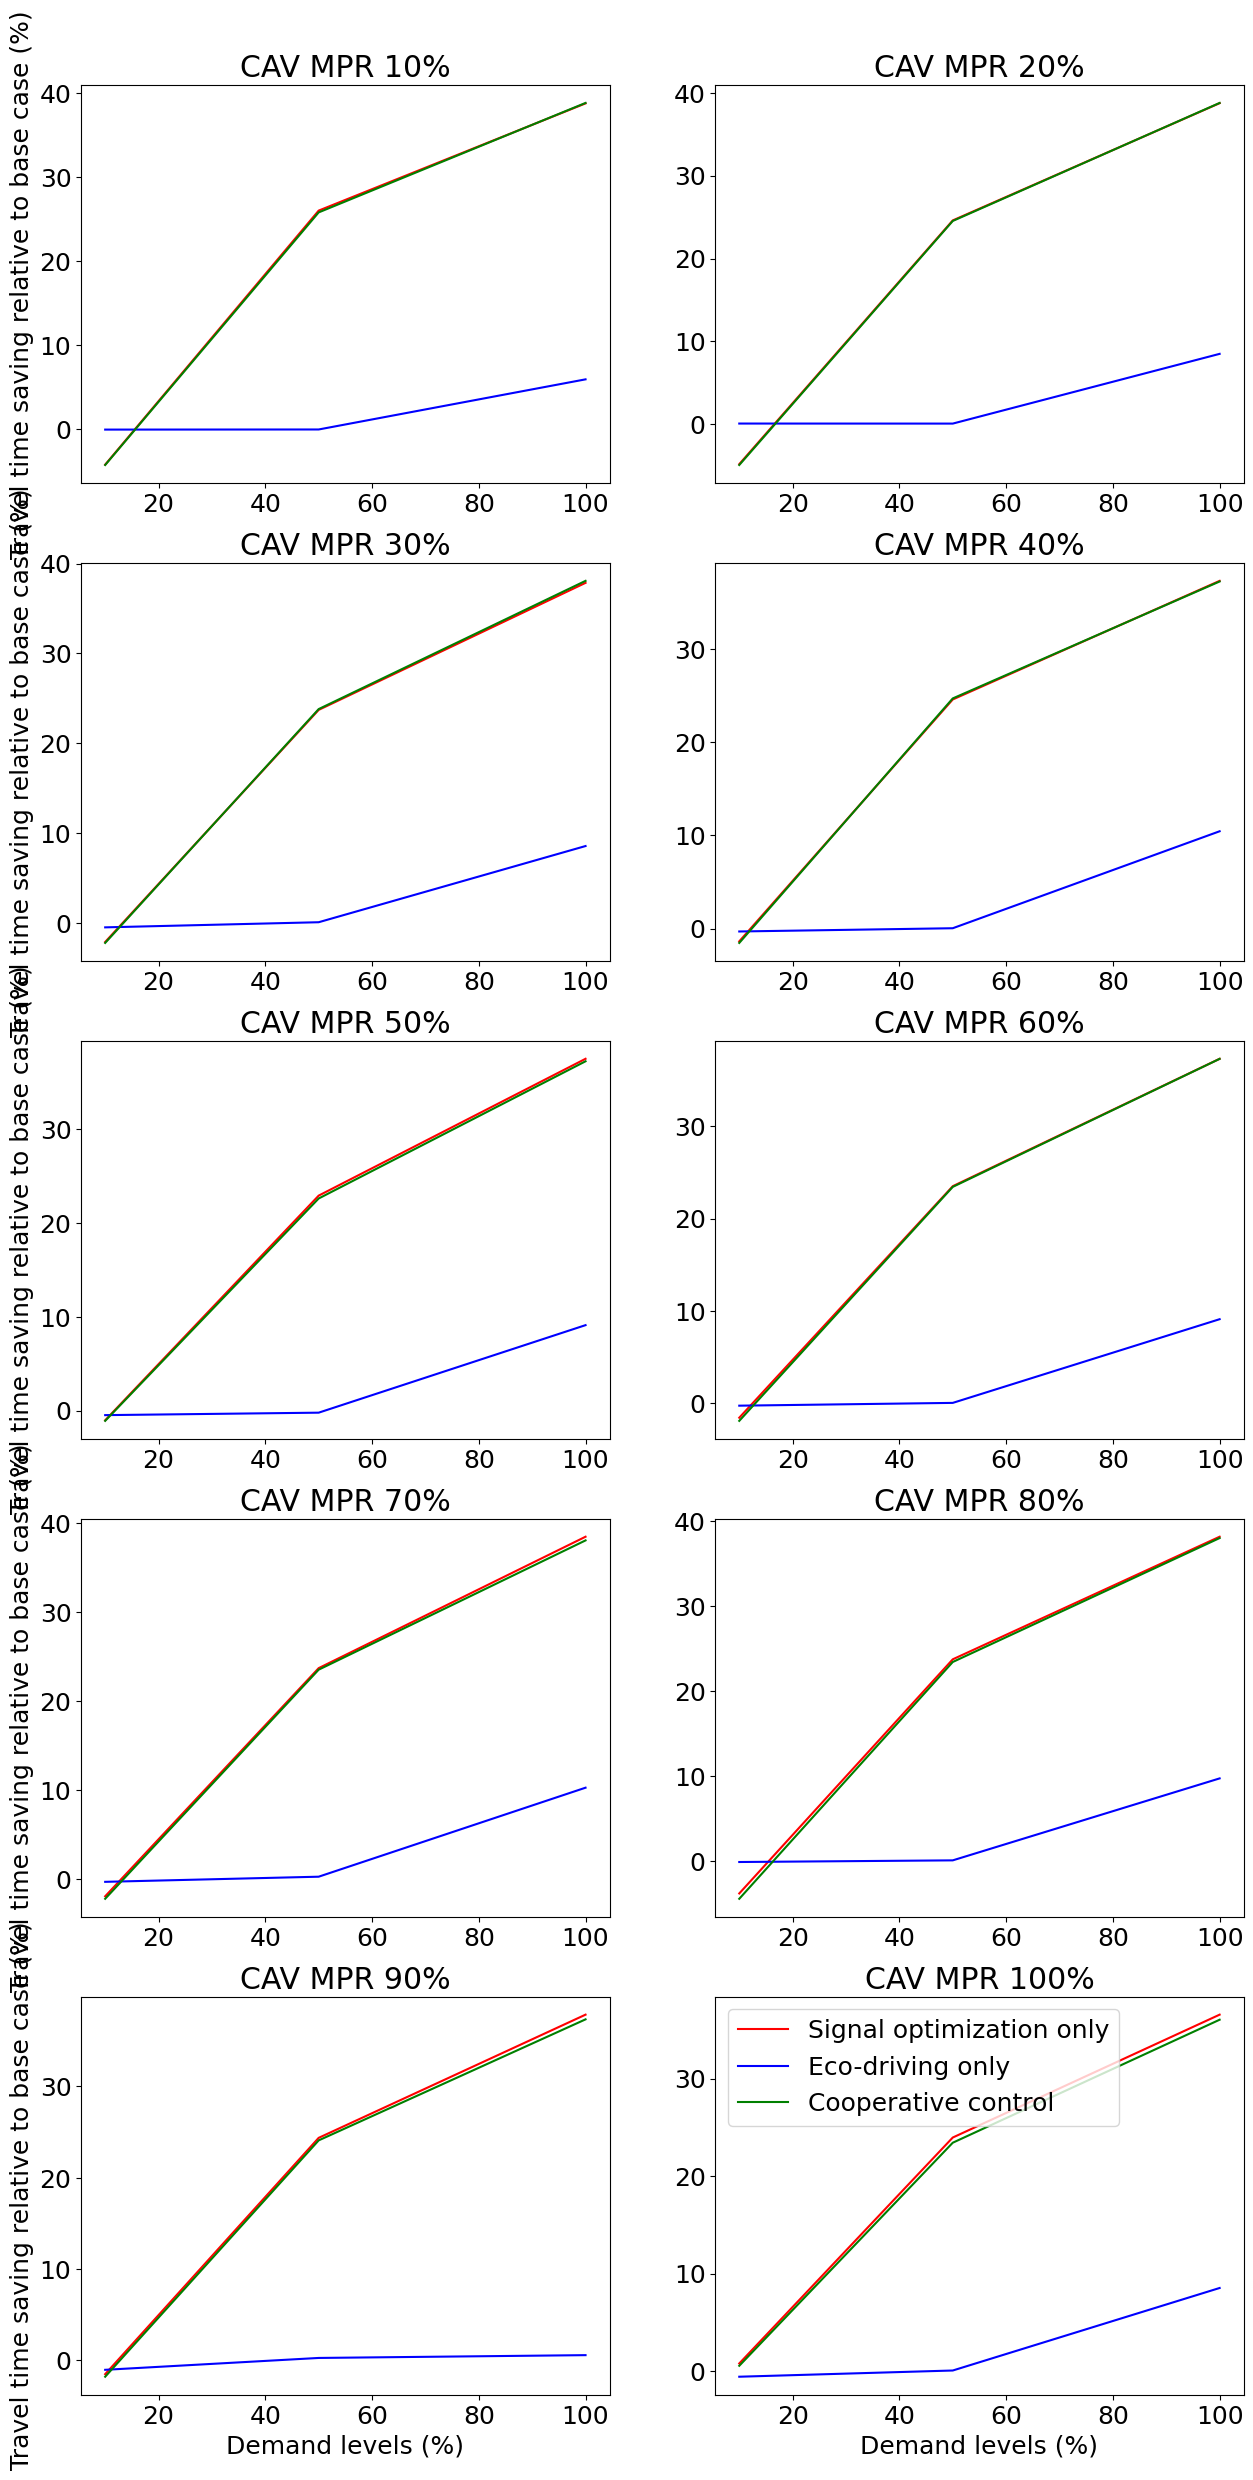

In [29]:
# travel_time_saving vs. cav_percent
cav_perct = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure(figsize=(15, 22))
num_row = 3
num_fig_per_row = int(len(demand_perct) / num_row)
subplot_idx = 1
plt.rcParams.update({'font.size': 18})

for demand in demand_perct:
    tt_saving_sig_opt = savings.loc[savings['demand'] == demand, 'signal_optimization_tt']
    tt_saving_eco_drive = savings.loc[savings['demand'] == demand, 'eco-drive_only_tt']
    tt_saving_cooperative_control = savings.loc[savings['demand'] == demand, 'cooperative_control_tt']

    plt.subplot(num_row, num_fig_per_row, subplot_idx)
    plt.plot(cav_perct, tt_saving_sig_opt, 'r')
    plt.plot(cav_perct, tt_saving_eco_drive, 'b')
    plt.plot(cav_perct,tt_saving_cooperative_control, 'g')
    plt.ylabel('Travel time saving relative to No_Control (%)')
    plt.title('Demand {}'.format(demand))

    if subplot_idx == len(demand_perct):
        plt.xlabel('CAV market penetration (%)')
        plt.legend(['Signal optimization only', 'Eco-driving only', 'Cooperative control'])
    
    subplot_idx += 1

# travel time saving vs. demand
cav_perct = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.figure(figsize=(15, 30))
num_row = 5
num_fig_per_row = int(len(cav_perct) / num_row)
subplot_idx = 1
plt.rcParams.update({'font.size': 18})

for cav in cav_perct:
    tt_saving_sig_opt = savings.loc[savings['cav'] == cav, 'signal_optimization_tt']
    tt_saving_eco_drive = savings.loc[savings['cav'] == cav, 'eco-drive_only_tt']
    tt_saving_cooperative_control = savings.loc[savings['cav'] == cav, 'cooperative_control_tt']
    
    plt.subplot(num_row, num_fig_per_row, subplot_idx)
    plt.plot(demand_perct, tt_saving_sig_opt, 'r')
    plt.plot(demand_perct, tt_saving_eco_drive, 'b')
    plt.plot(demand_perct, tt_saving_cooperative_control, 'g')
    plt.title('CAV MPR {}%'.format(cav))

    if subplot_idx % 2 == 1:
        plt.ylabel('Travel time saving relative to base case (%)')
    
    if subplot_idx == len(cav_perct)-1:
        plt.xlabel('Demand levels (%)')

    if subplot_idx == len(cav_perct):
        plt.xlabel('Demand levels (%)')
        plt.legend(['Signal optimization only', 'Eco-driving only', 'Cooperative control'])
    
    subplot_idx += 1

In [32]:
test = pd.read_csv('results/Signal_optimization_only_demand10_CAV70_5890.csv', delimiter='\t')
len(test.section_id.unique())

17